<a href="https://colab.research.google.com/github/Deriss/Tutoriais-Big-Data/blob/main/Tutorial_PySpark_M%C3%A9todos_de_redu%C3%A7%C3%A3o_de_dimensionalidade_e_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial PySpark - Métodos de redução de dimensionalidade e Clustering

# Instalar Dependencias

Para poder utilizar o PySpark no Google Colab, primeiro precisamos instalar algumas dependencias

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # java 8
!wget -q http://archive.apache.org/dist/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz #baixar o spark com Hadoop


In [2]:
!tar xf spark-3.3.3-bin-hadoop3.tgz # extrair os archivos do Spark
!pip install -q findspark # instalar biblioteca para achar o Spark no sistema

In [3]:
# Criando as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.3-bin-hadoop3"

# Inicializar o PySpark

In [4]:
# iniciando uma sessão local
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()  # O  * em local[*] indica que vamos utilizar todas as unidades de processamento disponíveis
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

# Baixando os Dados

In [6]:
!wget -q https://github.com/Deriss/TEP/raw/main/dados_free_teste.csv
!wget -q https://github.com/Deriss/TEP/raw/main/dados_free_treino.csv
!wget -q https://github.com/Deriss/TEP/raw/main/dados_treino_falha.csv
!wget -q https://github.com/Deriss/TEP/raw/main/dados_teste_falha.csv

# Carregar dados

Podemos carregar dados de diferentes fontes. Nesse tutorial vamos trabalhar com dados de exemplo do Spark disponibilizados em um arquivo csv.

In [7]:

# carregar dados exemplo
df_train = spark.read.csv("./dados_free_treino.csv", inferSchema=True, header=True)
df_val = spark.read.csv("./dados_free_teste.csv", inferSchema=True, header=True)
df_test = spark.read.csv("./dados_teste_falha.csv", inferSchema=True, header=True)


In [68]:
df_falha_1 = df_test.limit(960)

In [8]:
df_train.show(5)

+---+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+------+------+------+------+------+------+------+------+------+------+------+
|_c0|XMEAS_1|XMEAS_2|XMEAS_3|XMEAS_4|XMEAS_5|XMEAS_6|XMEAS_7|XMEAS_8|XMEAS_9|XMEAS_10|XMEAS_11|XMEAS_12|XMEAS_13|XMEAS_14|XMEAS_15|XMEAS_16|XMEAS_17|XMEAS_18|XMEAS_19|XMEAS_20|XMEAS_21|XMEAS_22|XMEAS_23|XMEAS_24|XMEAS_25|XMEAS_26|XMEAS_27|XMEAS_28|XMEAS_29|XMEAS_30|XMEAS_31|XMEAS_32|XMEAS_33|XMEAS_34|XMEAS_35|XMEAS_36|XMEAS_37|XMEAS_38|XMEAS_39|XMEAS_40|XMEAS_41| XMV_1| XMV_2| XMV_3| XMV_4| XMV_5| XMV_6| XMV_7| XMV_8| XMV_9|XMV_10|XMV_11|
+---+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+-

sample,XMEAS_1,XMEAS_2,XMEAS_3,XMEAS_4,XMEAS_5,XMEAS_6,XMEAS_7,XMEAS_8,XMEAS_9,XMEAS_10,XMEAS_11,XMEAS_12,XMEAS_13,XMEAS_14,XMEAS_15,XMEAS_16,XMEAS_17,XMEAS_18,XMEAS_19,XMEAS_20,XMEAS_21,XMEAS_22,XMEAS_23,XMEAS_24,XMEAS_25,XMEAS_26,XMEAS_27,XMEAS_28,XMEAS_29,XMEAS_30,XMEAS_31,XMEAS_32,XMEAS_33,XMEAS_34,XMEAS_35,XMEAS_36,XMEAS_37,XMEAS_38,XMEAS_39,XMEAS_40,XMEAS_41,XMV_1,XMV_2,XMV_3,XMV_4,XMV_5,XMV_6,XMV_7,XMV_8,XMV_9,XMV_10,XMV_11
0,0.25025,3657.2,4520.1,9.3965,26.715,42.191,2704.5,74.593,120.42,0.33701,80.05,48.281,2632.5,23.661,51.052,3102.5,22.987,65.724,230.18,341.61,94.544,77.049,32.188,8.8933,26.383,6.882,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.8357,0.098577,53.724,43.828,63.171,53.85,24.67,61.839,22.101,40.078,33.041,48.969,47.459,41.841,18.049
1,0.25135,3662.1,4532.3,9.402,26.644,42.812,2704.9,75.044,120.39,0.33723,80.058,50.358,2633.5,24.866,51.441,3102.7,23.004,65.7,230.82,341.54,94.594,77.106,32.188,8.8933,26.383,6.882,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.8357,0.098577,53.724,43.828,63.086,53.705,24.562,61.348,22.264,40.05,39.154,49.87,47.403,41.188,18.008
2,0.25045,3681.9,4493.6,9.2395,26.971,42.282,2705.0,75.405,120.42,0.33643,80.131,50.406,2633.8,23.855,49.126,3101.9,22.981,65.717,232.39,341.57,94.666,77.777,31.822,8.9921,26.465,6.8051,18.744,1.6755,32.72,13.87,24.125,1.2235,18.591,2.2871,4.8855,2.3619,0.017866,0.8357,0.098577,53.724,43.828,62.745,54.167,24.659,61.826,22.312,40.147,39.294,44.511,47.265,41.29,18.009
3,0.25056,3667.9,4466.0,9.3602,26.937,42.194,2705.9,75.397,120.41,0.33891,80.215,49.4,2634.9,24.319,49.842,3103.9,23.095,65.76,230.73,341.28,94.539,77.171,31.822,8.9921,26.465,6.8051,18.744,1.6755,32.72,13.87,24.125,1.2235,18.591,2.2871,4.8855,2.3619,0.017866,0.8357,0.098577,53.724,43.828,62.985,54.498,24.648,63.168,22.288,39.845,36.334,46.168,47.41,40.997,17.771
4,0.28659,3693.0,4502.5,9.5652,26.999,42.54,2704.3,74.749,120.39,0.34173,79.977,48.906,2632.4,26.103,49.586,3103.2,22.429,65.749,230.58,341.12,94.594,77.095,32.465,8.8021,26.434,6.8798,18.418,1.6352,32.819,13.852,24.108,1.1785,18.46,2.2185,4.842,2.2426,0.017866,0.8357,0.098577,53.724,43.828,63.265,54.142,28.43,57.566,22.142,40.806,34.882,45.576,47.424,41.29,19.371
5,0.28583,3684.4,4507.9,9.2356,26.806,42.361,2704.6,75.749,120.41,0.34009,80.05,50.461,2632.7,26.324,49.253,3103.2,22.589,65.721,231.9,341.55,94.515,77.371,32.465,8.8021,26.434,6.8798,18.418,1.6352,32.819,13.852,24.108,1.1785,18.46,2.2185,4.842,2.2426,0.015285,0.82183,0.086216,54.047,44.618,63.414,54.077,28.505,62.912,21.915,41.005,39.457,44.805,47.308,41.801,18.979
6,0.22711,3683.1,4534.6,9.3129,27.369,42.257,2704.8,75.744,120.41,0.34103,80.158,49.124,2633.1,24.144,50.515,3102.4,23.198,65.737,231.14,341.59,94.551,77.244,31.588,8.8503,26.21,6.7487,18.505,1.6805,32.579,13.88,23.872,1.3306,18.64,2.2298,4.8107,2.2818,0.015285,0.82183,0.086216,54.047,44.618,62.817,54.592,22.141,61.719,22.29,40.461,35.523,47.726,47.376,41.208,17.532
7,0.22718,3660.9,4530.4,9.3504,26.824,42.552,2705.0,75.223,120.41,0.34259,80.251,50.408,2633.4,24.471,48.339,3102.5,23.136,65.748,230.53,341.5,94.648,77.439,31.588,8.8503,26.21,6.7487,18.505,1.6805,32.579,13.88,23.872,1.3306,18.64,2.2298,4.8107,2.2818,0.015285,0.82183,0.086216,54.047,44.618,63.2,54.642,22.134,61.264,22.259,40.272,39.3,42.69,47.427,41.815,17.644
8,0.31198,3705.5,4511.7,9.2332,27.009,42.342,2706.7,74.966,120.38,0.34617,80.357,50.196,2635.7,24.821,51.265,3106.0,23.441,65.781,230.47,340.94,94.412,77.823,32.382,9.0133,26.458,7.0752,18.907,1.6873,32.615,13.698,24.034,1.1127,19.179,2.2797,4.8851,2.2659,0.015285,0.82183,0.086216,54.047,44.618,63.645,54.706,30.812,64.592,22.028,40.632,38.676,49.461,47.428,41.13,16.885
9,0.31262,3748.1,4564.5,9.3079,27.075,42.114,2706.1,74.822,120.42,0.34086,80.283,50.459,2634.6,23.248,47.825,3106.0,22.566,65.829,229.86,340.81,94.359,77.068,32.382,9.0133,26.458,7.0752,18.907,1.6873,32.615,13.698,24.034,1.1127,19.179,2.2797,4.8851,2.2659

In [9]:
df_val.show(5)

+---+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+------+------+------+------+------+------+------+------+------+------+------+
|_c0|XMEAS_1|XMEAS_2|XMEAS_3|XMEAS_4|XMEAS_5|XMEAS_6|XMEAS_7|XMEAS_8|XMEAS_9|XMEAS_10|XMEAS_11|XMEAS_12|XMEAS_13|XMEAS_14|XMEAS_15|XMEAS_16|XMEAS_17|XMEAS_18|XMEAS_19|XMEAS_20|XMEAS_21|XMEAS_22|XMEAS_23|XMEAS_24|XMEAS_25|XMEAS_26|XMEAS_27|XMEAS_28|XMEAS_29|XMEAS_30|XMEAS_31|XMEAS_32|XMEAS_33|XMEAS_34|XMEAS_35|XMEAS_36|XMEAS_37|XMEAS_38|XMEAS_39|XMEAS_40|XMEAS_41| XMV_1| XMV_2| XMV_3| XMV_4| XMV_5| XMV_6| XMV_7| XMV_8| XMV_9|XMV_10|XMV_11|
+---+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+-

In [10]:
df_test.show(5)

+---+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+------+------+------+------+------+------+------+------+------+------+------+
|_c0|XMEAS_1|XMEAS_2|XMEAS_3|XMEAS_4|XMEAS_5|XMEAS_6|XMEAS_7|XMEAS_8|XMEAS_9|XMEAS_10|XMEAS_11|XMEAS_12|XMEAS_13|XMEAS_14|XMEAS_15|XMEAS_16|XMEAS_17|XMEAS_18|XMEAS_19|XMEAS_20|XMEAS_21|XMEAS_22|XMEAS_23|XMEAS_24|XMEAS_25|XMEAS_26|XMEAS_27|XMEAS_28|XMEAS_29|XMEAS_30|XMEAS_31|XMEAS_32|XMEAS_33|XMEAS_34|XMEAS_35|XMEAS_36|XMEAS_37|XMEAS_38|XMEAS_39|XMEAS_40|XMEAS_41| XMV_1| XMV_2| XMV_3| XMV_4| XMV_5| XMV_6| XMV_7| XMV_8| XMV_9|XMV_10|XMV_11|
+---+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+-

In [12]:
df_train = df_train.withColumnRenamed('_c0','sample')
df_val = df_val.withColumnRenamed('_c0','sample')
df_test = df_test.withColumnRenamed('_c0','sample')


# Métodos de redução de dimensionalidade

## PCA

In [13]:
from pyspark.ml.feature import PCA

In [92]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
columns_to_scale = [f'XMEAS_{i}' for i in range(1,42)]
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [StandardScaler(inputCol=col + "_vec", outputCol=col + "_scaled", withMean = True) for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(df_train)
scaled_train = scalerModel.transform(df_train)

In [93]:
scaled_val = scalerModel.transform(df_val)
scaled_test = scalerModel.transform(df_test)
scaled_falha_1  = scalerModel.transform(df_falha_1)

In [94]:
scaled_train.show(5)

+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+------+------+------+------+------+------+------+------+------+------+------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+----------

In [95]:
from pyspark.ml.feature import VectorAssembler

# Make a VectorAssembler
vec_assembler = VectorAssembler(inputCols=[f'XMEAS_{i}_scaled' for i in range(1,20)],
                                outputCol='input_features')

In [96]:
pca = PCA(k=3,inputCol="input_features")

In [97]:
pca.setOutputCol("pca_features")

PCA_e247d5f5afcc

In [98]:
pipeline_pca = Pipeline(stages = [vec_assembler, pca])

In [99]:
pcaModel = pipeline_pca.fit(scaled_train)

In [100]:
pca_results = pcaModel.transform(scaled_train)

In [101]:
pca_results.show(5)

+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+------+------+------+------+------+------+------+------+------+------+------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+----------

In [102]:
pcaModel.stages[-1].explainedVariance

DenseVector([0.2085, 0.0852, 0.0721])

In [103]:
import matplotlib.pyplot as plt

In [104]:
pca_component1  = pca_results.select("pca_features").rdd.map(lambda x: x.pca_features[0]).collect()
pca_component2  = pca_results.select("pca_features").rdd.map(lambda x: x.pca_features[1]).collect()
pca_component3  = pca_results.select("pca_features").rdd.map(lambda x: x.pca_features[2]).collect()

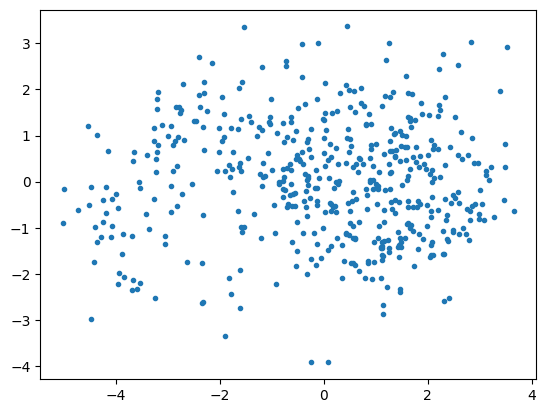

In [105]:
x = pca_component1
y = pca_component2
plt.plot(x,y,'.')

# PCA val and test

In [106]:
pca_results_val = pcaModel.transform(scaled_val)

In [107]:
pca_results_falha = pcaModel.transform(scaled_test)

In [108]:
pca_results_falha_1 = pcaModel.transform(scaled_falha_1)

In [109]:
pca_component1_val  = pca_results_val.select("pca_features").rdd.map(lambda x: x.pca_features[0]).collect()
pca_component2_val = pca_results_val.select("pca_features").rdd.map(lambda x: x.pca_features[1]).collect()

In [110]:
pca_component1_falha  = pca_results_falha.select("pca_features").rdd.map(lambda x: x.pca_features[0]).collect()
pca_component2_falha = pca_results_falha.select("pca_features").rdd.map(lambda x: x.pca_features[1]).collect()

In [111]:
pca_component1_falha_1  = pca_results_falha_1.select("pca_features").rdd.map(lambda x: x.pca_features[0]).collect()
pca_component2_falha_1  = pca_results_falha_1.select("pca_features").rdd.map(lambda x: x.pca_features[1]).collect()

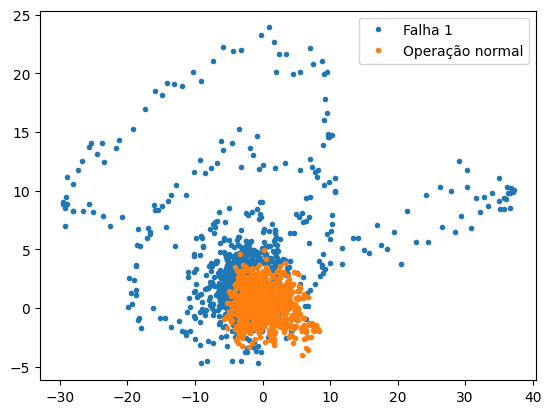

In [113]:
plt.plot(pca_component1_falha_1,pca_component2_falha_1,'.')
plt.plot(pca_component1_val,pca_component2_val,'.')
plt.legend(['Falha 1','Operação normal'])

# Clustering

## K-means

In [117]:
scaled_falha_1.show()

+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+------+------+------+------+------+------+------+------+------+------+------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+----------

In [124]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=2).setSeed(1)
kmeans.setFeaturesCol('input_features')


pipeline_kmeans = Pipeline(stages = [vec_assembler, kmeans])
kmeansModel = pipeline_kmeans.fit(scaled_falha_1)
kmeansModel.stages[-1].setPredictionCol("kmeansPrediction")
kmeans_results  = kmeansModel.transform(scaled_falha_1)

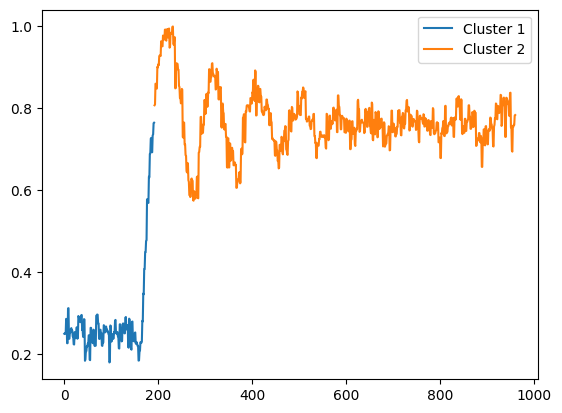

In [142]:
plt.plot(kmeans_results.filter(kmeans_results.kmeansPrediction == 1).select('sample').collect(),kmeans_results.filter(kmeans_results.kmeansPrediction == 1).select('XMEAS_1').collect(),label='Cluster 1')
plt.plot(kmeans_results.filter(kmeans_results.kmeansPrediction == 0).select('sample').collect(),kmeans_results.filter(kmeans_results.kmeansPrediction == 0).select('XMEAS_1').collect(),label = 'Cluster 2')
plt.legend()
plt.show()

In [140]:
kmeans2 = KMeans(k=2).setSeed(1)
kmeans2.setFeaturesCol('pca_features')



kmeans2Model = kmeans2.fit(pca_results_falha_1)
kmeans2Model.setPredictionCol("kmeansPrediction2")
kmeans2_results= kmeans2Model.transform(pca_results_falha_1)